# import library

In [1]:
import numpy as np
import ot
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.cluster import SpectralClustering
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
from HOTDA import *
warnings.filterwarnings("ignore")

In [2]:
class Model_HOT_DA:
    def __init__(self,kernel='rbf'):
        self.kernel=kernel
        self.classifier=svm.SVC()
        self.theta=0
        self.deg=0
        
    def fit(self,X,y,X_test,deg):
        self.deg=deg
        self.theta=  np.deg2rad(self.deg)
        self.rotMat = rotationMat(self.theta)
        self.X = X - np.mean(X, axis = 0)
        self.y=y
        self.X_test = X_test - np.mean(X_test, axis = 0)
        self.X_test = np.dot(self.X_test, self.rotMat.T)
        self.clustering = SpectralClustering(n_clusters=2, eigen_solver='arpack', assign_labels='kmeans',affinity="nearest_neighbors").fit(self.X_test)     #we can use wasserstein SpectralClustering instead of SpectralClustering
        S,a,mu,self.y_Transported_S=Source_target_processing(self.X,self.y)
        T,b,nu,yxyys=Source_target_processing(self.X_test,self.clustering.labels_)  
        HOT,W=Hot(S,a,mu,T,b,nu,0.1,0.1)
        self.X_Transported_S=Mapping(S,T,a,b,HOT)
        self.classifier = svm.SVC(kernel=self.kernel)
        self.classifier.fit(self.X_Transported_S,self.y_Transported_S)
        
        
    def predict(self,X_test,y_t):
        self.y_test=y_t
        return self.classifier.score(self.X_test,y_t)
        
    def plot(self):
        self.x_s_plt=[num for elem in self.X[:,:1].tolist() for num in elem]
        self.y_s_plt=[num for elem in self.X[:,1:2].tolist() for num in elem]
        self.col_s_plt=self.y


        self.x_test_plt=[num for elem in self.X_test[:,:1].tolist() for num in elem]
        self.y_test_plt=[num for elem in self.X_test[:,1:2].tolist() for num in elem]
        self.col_test_plt=self.y_test.tolist()

        self.x_test=[num for elem in self.X_test[:,:1].tolist() for num in elem]
        self.y_test=[num for elem in self.X_test[:,1:2].tolist() for num in elem]
        self.col__prj_plt=self.y_test
        self.x=[elem[0] for elem in self.X_Transported_S]
        self.y=[elem[1] for elem in self.X_Transported_S]
        self.x0=self.x[:150]
        self.y0=self.y[:150]
        self.x1=self.x[150:]
        self.y1=self.y[150:]
        plt.figure(figsize= (6,5))
        h = .002
        x_min, x_max = -2 ,2
        y_min, y_max = -3 , +3
        xx, yy =np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = self.classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, cmap='Blues')
        sns.kdeplot(self.x0, 
            self.y0, color='b',
            shade=True,
            cmap="Blues", shade_lowest=False,thresh=0.37, levels=1000 )
        sns.kdeplot(self.x1,
                    self.y1, shade=True, 
                    cmap="Reds",color='r', shade_lowest=False,thresh=0.37, levels=1000)
        x1 = []
        x2 = []
        for i in range(0, len(self.col_s_plt)) :
            if self.col_s_plt[i] == 0 :
                x1.append(self.x_s_plt[i])
                x2.append(self.y_s_plt[i])
        x11 = []
        x22 = []
        for i in range(0, len(self.col_s_plt)) :
            if self.col_s_plt[i] == 1 :
                x11.append(self.x_s_plt[i])
                x22.append(self.y_s_plt[i])
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        x1_c = []
        x2_c = []
        for i in range(0, len(self.col_test_plt)) :
            if self.col_test_plt[i] == 1 :
                x1_c.append(self.x_test_plt[i])
                x2_c.append(self.y_test_plt[i])
        x1_c1 = []
        x2_c2 = []
        for i in range(0, len(self.col_test_plt)) :
            if self.col_test_plt[i] == 0 :
                x1_c1.append(self.x_test_plt[i])
                x2_c2.append(self.y_test_plt[i])
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.09)     
        plt.scatter(x1,x2, c='#7879fa',edgecolors= "k", alpha= 0.5,label="Source")
        plt.scatter(x11,x22, c='#fe6f66',edgecolors= "k", alpha= 0.5)
        plt.scatter(x1_c, x2_c, c='#fd0000', marker= 'v', edgecolors= "k");
        plt.scatter(x1_c1, x2_c2, c='#0000fd',marker= 'v', edgecolors= "k",label="Target");
        plt.legend(loc=0)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        

def rotationMat(rotTheta):
    return np.array([[np.cos(rotTheta), -np.sin(rotTheta)], 
                     [np.sin(rotTheta), np.cos(rotTheta)]])

0


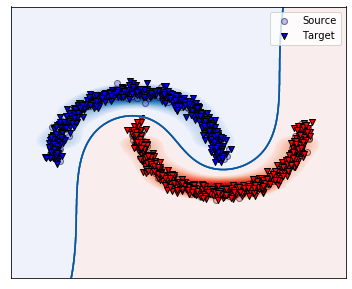

10


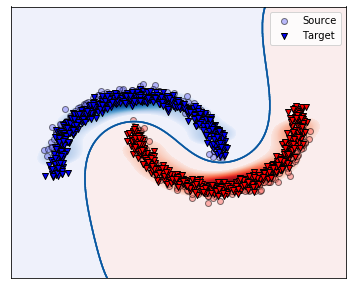

20


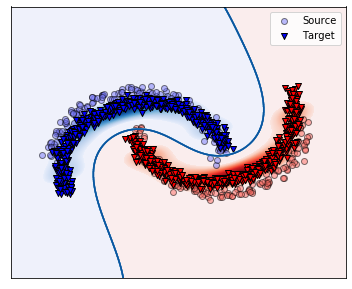

30


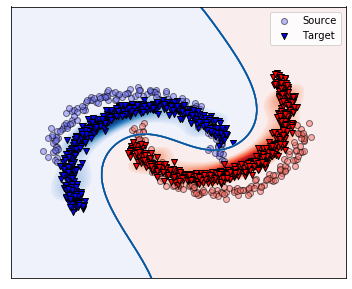

40


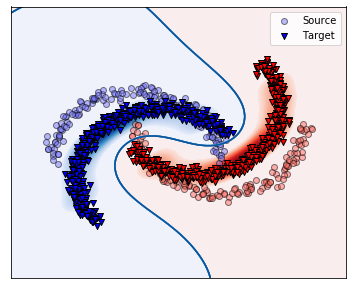

50


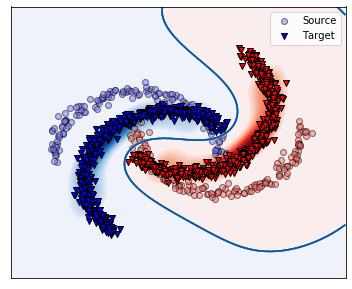

60


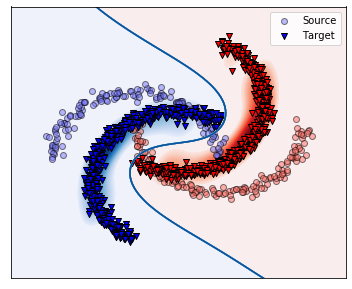

70


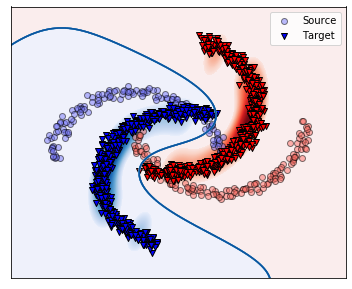

80


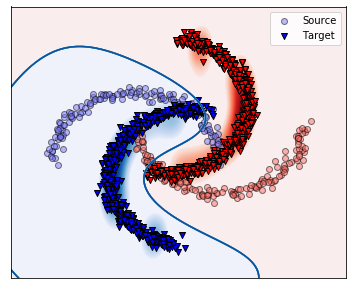

90


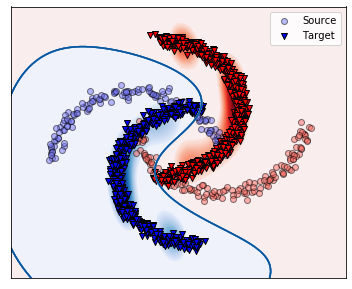

In [4]:
for degre in range(0, 91, 10):
    X, y = datasets.make_moons(300, noise= 0.05)
    X_T,y_T=datasets.make_moons(1000, noise= 0.05)
    model=Model_HOT_DA()
    print(degre)
    model.fit(X, y,X_T,degre)
    model.predict(X_T,y_T)
    X_T_transforme=np.dot(X_T, rotationMat(np.deg2rad(degre)).T)
    model.plot()